<h1 align='center'><b>Фреймворк PyTorch для разработки искусственных нейронных сетей<b></h1>

<h2 align='center'>Урок 10. Распознавание лиц и эмоций</h2>

<h2 align='left'>Оглавление:</h2>

* [Постановка задачи](#target_setting)  
* [Подготовка](#preparation)  
** [Библиотеки](#libraries)  
** [Скрипты](#scripts)  
** [Функции](#functions)  
** [Познакомимся с данными](#data)  
** [Разделение на train и test](#split)  
** [Создаём Dataset](#dataset)  
** [Создаём загрузчик данных DataLoader](#dataloader)  
* [Создание модели](#model)  
** [Обучение модели](#training)  
** [Сохранение модели](#saving)  
* [Работа модели](#working)  
* [Вывод](#summary)  

## Постановка задачи<a class="anchor" id="target_setting"></a>

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.

В процессе считывания определять, что перед камерой находится человек, задетектировав его лицо на кадре.

Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ



## Подготовка<a class="anchor" id="preparation"></a>
Подключаем нужные модули и библиотеки

### Библиотеки<a class="anchor" id="libraries"></a>

In [1]:
!pip install -qq mediapipe
!pip install -qq facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00


In [2]:
import os

import numpy as np

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from facenet_pytorch import MTCNN

import torchvision
import torchvision.transforms as tt

from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

from collections import Counter

import mediapipe as mp

from tqdm import tqdm
import cv2

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time

import matplotlib.pyplot as plt

### Скрипты<a class="anchor" id="scripts"></a>

Js скрипты для захвата камеры в Google Colab

Источник: https://www.youtube.com/watch?v=YjWh7QvVH60

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [4]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '800px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});

      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Функции<a class="anchor" id="functions"></a>

Функция для распознавания лица

In [5]:
def face_detect(mtcnn, flip_img, bbox_array, face_box_color, face_landmarks_color):

    # get face region coordinates
    boxes, probs, landmarks = mtcnn.detect(flip_img, landmarks=True)
    # get face bounding box for overlay
    if boxes is not None:
      # Draw rectangle on frame
      for (a,b,c,d) in boxes.astype(int):
        bbox_array = cv2.rectangle(bbox_array,(a,b),(c,d),face_box_color, thickness=2)
      # Draw landmarks
      for face_landmarks in landmarks.astype(int):
        for landmark in face_landmarks:
          bbox_array = cv2.circle(bbox_array, tuple(landmark), 4, face_landmarks_color, -1)

    return boxes, bbox_array

### Познакомимся с данными<a class="anchor" id="data"></a>

Подключение в Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Для обучения нейронной сети будем использовать этот [датасет](https://www.kaggle.com/gti-upm/leapgestrecog) (2.1 GB).
Загрузим его и распакуем содержимое в папки.

**Контекст**

Представлена ​​база данных распознавания жестов рук, состоящая из набора изображений в ближнем инфракрасном диапазоне, полученных датчиком Leap Motion.

**Содержание**

База данных состоит из 10 различных жестов рук (показанных выше), которые были выполнены 10 различными субъектами (5 мужчин и 5 женщин).  
База данных структурирована в разных папках следующим образом:  
    • /00 (тема с идентификатором 00)  
        ◦ /01_palm (изображения для жеста ладони субъекта 00 )  
            ▪ /01_palm/frame_197957_r.png,…,frame_198136_l.png, … (изображения, соответствующие различным образцам, полученным для жеста ладони, выполненного субъектом с идентификатором 00)  
        ◦ /02_l (изображения для l жеста субъекта 00 )  
        ◦ /10_вниз  
    • /01  
    • /02  
    • /09 (последний субъект с идентификатором 09)  
Каждая корневая папка (00, 01,…) содержит инфракрасные изображения одного объекта. Имя папки является идентификатором каждого отдельного субъекта.

In [7]:
!unzip -qq '/content/drive/MyDrive/Colab_Notebooks/24_PyTorch/work_10/data/archive.zip'

In [8]:
DATA_ROOT = Path('./leapGestRecog')

In [9]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [10]:
for data in os.listdir(DATA_ROOT):
  print(f'********* {data} **********')
  for gesture in os.listdir(f"{DATA_ROOT}/{data}"):
    print(gesture, len(os.listdir(f"{DATA_ROOT}/00/{gesture}")))

********* 00 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 09 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 07 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 08 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 05 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 01 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 200
01_palm 200
07_ok 200
03_fist 200
05_thumb 200
********* 02 **********
08_palm_moved 200
09_c 200
02_l 200
10_down 200
04_fist_moved 200
06_index 2

In [11]:
data_list = []
labels_list = []


for data in os.listdir(DATA_ROOT):
    for gesture in os.listdir(f"{DATA_ROOT}/{data}"):
        imgs =  os.listdir(f"{DATA_ROOT}/{data}/{gesture}")
        for img in imgs:
            data_list.append(f"{DATA_ROOT}/{data}/{gesture}/{img}")
            labels_list.append(int(gesture[:2]))

In [12]:
print(len(data_list))
print(len(labels_list))

20000
20000


In [13]:
data_list[300:320]

['leapGestRecog/00/09_c/frame_00_09_0152.png',
 'leapGestRecog/00/09_c/frame_00_09_0140.png',
 'leapGestRecog/00/09_c/frame_00_09_0027.png',
 'leapGestRecog/00/09_c/frame_00_09_0163.png',
 'leapGestRecog/00/09_c/frame_00_09_0141.png',
 'leapGestRecog/00/09_c/frame_00_09_0100.png',
 'leapGestRecog/00/09_c/frame_00_09_0200.png',
 'leapGestRecog/00/09_c/frame_00_09_0156.png',
 'leapGestRecog/00/09_c/frame_00_09_0125.png',
 'leapGestRecog/00/09_c/frame_00_09_0057.png',
 'leapGestRecog/00/09_c/frame_00_09_0025.png',
 'leapGestRecog/00/09_c/frame_00_09_0012.png',
 'leapGestRecog/00/09_c/frame_00_09_0120.png',
 'leapGestRecog/00/09_c/frame_00_09_0091.png',
 'leapGestRecog/00/09_c/frame_00_09_0174.png',
 'leapGestRecog/00/09_c/frame_00_09_0054.png',
 'leapGestRecog/00/09_c/frame_00_09_0020.png',
 'leapGestRecog/00/09_c/frame_00_09_0022.png',
 'leapGestRecog/00/09_c/frame_00_09_0089.png',
 'leapGestRecog/00/09_c/frame_00_09_0136.png']

In [14]:
labels_list[300:320]

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Достанем случайное изображение:

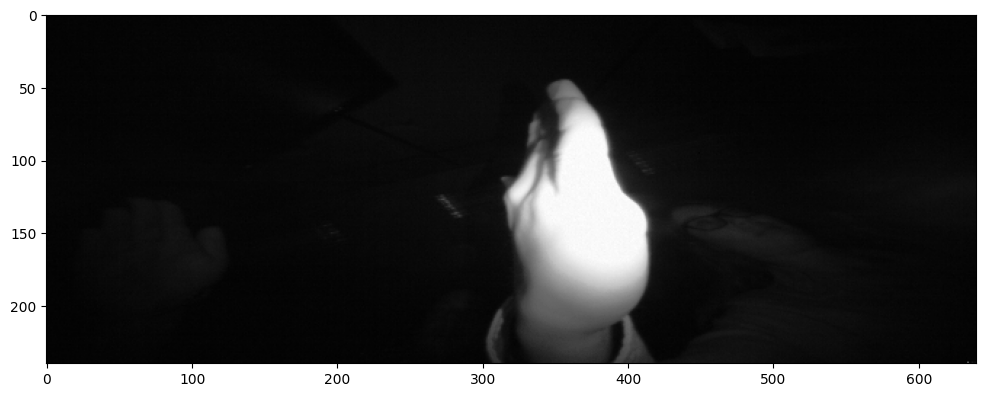

In [15]:
img = plt.imread(data_list[0])
plt.figure(figsize = (12,12))
plt.imshow(img, cmap='gray');

In [16]:
img.shape

(240, 640)

Для классификации жестов рук воспользуемся библиотекой [mediapipe](https://developers.google.com/mediapipe).

Получим ключевые точки рук (landmarks) для наших данных:

In [17]:
%%time
hands = mp.solutions.hands.Hands(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        max_num_hands=1) # 1 так как на каждой фотографии только один жест
# обьединим данные
data = data_list
labels = labels_list
data_landmarks = []
labels_landmarks = []
for i in tqdm(range(len(labels))):
  image = cv2.imread(data[i])
  results = hands.process(image)
  if results.multi_hand_landmarks:
    landmarks = []
    for landmark in results.multi_hand_landmarks[0].landmark:
      landmarks.append([landmark.x, landmark.y])
    # !!! Нормализуем данные от 0 до 1 (min-max normalisation) !!!
    landmarks = np.array(landmarks)
    landmarks[:,0] -= min(landmarks[:,0])
    landmarks[:,1] -= min(landmarks[:,1])
    landmarks[:,0] /= max(landmarks[:,0])
    landmarks[:,1] /= max(landmarks[:,1])
    data_landmarks.append(landmarks)   
    labels_landmarks.append(labels[i])

100%|██████████| 20000/20000 [14:04<00:00, 23.67it/s]

CPU times: user 12min 49s, sys: 8.24 s, total: 12min 57s
Wall time: 14min 4s


Посмотрим, что получилось

In [18]:
count_labels_landmarks = {}
for i in range(1,11):
    count_labels_landmarks[CLASSES_NAME[i-1]] = labels_landmarks.count(i)
count_labels_landmarks

{'01_palm': 1730,
 '02_l': 1025,
 '03_fist': 444,
 '04_fist_moved': 172,
 '05_thumb': 661,
 '06_index': 620,
 '07_ok': 1625,
 '08_palm_moved': 241,
 '09_c': 444,
 '10_down': 1390}

Распознались не все изображения. Присутствует сильный дисбаланс. Попробуем его устранить:

In [19]:
class_count = np.array(list(count_labels_landmarks.values())).astype(float)
class_weights = max(class_count)
class_weights /= class_count
class_weights

array([ 1.        ,  1.68780488,  3.8963964 , 10.05813953,  2.6172466 ,
        2.79032258,  1.06461538,  7.17842324,  3.8963964 ,  1.24460432])

### Разделение на train и test<a class="anchor" id="split"></a>

Разобьем наши данные на train и test в соотношении 80/20 так, чтобы в обучающей и тестовой выборке были одинаковые соотношения классов:

In [20]:
test_size = 0.2

train_data_landmarks = []
train_labels_landmarks = []
test_data_landmarks = []
test_labels_landmarks = []

data_landmarks = np.array(data_landmarks)
labels_landmarks = np.array(labels_landmarks)

for i in range(1,11):
    mask = (labels_landmarks==i)
    trashold = int((1-test_size)*sum(mask))
    train_data_landmarks.extend(data_landmarks[mask][:trashold])
    train_labels_landmarks.extend([i]*trashold)
    test_data_landmarks.extend(data_landmarks[mask][trashold:])
    test_labels_landmarks.extend([i]*(sum(mask)-trashold))

### Создаём Dataset<a class="anchor" id="dataset"></a>

In [21]:
class MyDataset(Dataset):
    def __init__(self, data_landmarks, labels_landmarks):
      
      self.data_landmarks = data_landmarks
      self.labels_landmarks = labels_landmarks

    def __getitem__(self, index):
      data = torch.FloatTensor(self.data_landmarks[index])
      label = self.labels_landmarks[index] - 1

      return data, label

    def __len__(self):
      return len(self.labels_landmarks)

In [22]:
train_dataset = MyDataset(train_data_landmarks, train_labels_landmarks)
test_dataset = MyDataset(test_data_landmarks, test_labels_landmarks)

### Создаём загрузчик данных DataLoader<a class="anchor" id="dataloader"></a>

In [23]:
BATCH_SIZE = 16

In [24]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

drop_last=True, так как нет уверенности, что в последнем пакете будет хотя бы одно значение

## Создание модели<a class="anchor" id="model"></a>

In [25]:
class MyNet(nn.Module):
    def __init__(self, in_channel, length, hidden_dim, num_classes, dropout):
        super().__init__()
        self.linear_1 = nn.Linear(in_channel*length, hidden_dim)
        self.bn_1 = nn.BatchNorm1d(hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn_2 = nn.BatchNorm1d(hidden_dim // 2)
        self.linear_3 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dp = nn.Dropout(dropout)
        
    def forward(self, x):  
        x = torch.flatten(x, start_dim=1)

        output = self.linear_1(x)
        output = self.bn_1(output)
        output = self.relu(output)
        output = self.dp(output)

        output = self.linear_2(output)
        output = self.bn_2(output)
        output = self.relu(output)
        output = self.dp(output)
        
        output = self.linear_3(output)
        return output

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
model = MyNet(data_landmarks.shape[2], data_landmarks.shape[1], 512, len(CLASSES_NAME), 0.2)
model = model.to(device)
model.train()

MyNet(
  (linear_1): Linear(in_features=42, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (bn_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.2, inplace=False)
)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device), reduction='mean')

Так как классы теперь несбалансированны, то accuracy уже не является хорошей метрикой, поэтому будем использовать f1_score

### Обучение модели<a class="anchor" id="training"></a>

In [29]:
%%time

epochs = 20

for epoch_num in range(epochs):
    train_loss = 0
    test_loss = 0    
    test_f1 = 0
    
    model.train()
    for landmarks, labels in tqdm(train_loader):
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        output = model(landmarks)
                
        loss = criterion(output, labels)
        train_loss += loss.item()        

        model.zero_grad()
        loss.backward()
        optimizer.step()
            
    model.eval()
    for landmarks, labels in test_loader:
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        output = model(landmarks)

        loss = criterion(output, labels)
        test_loss += loss.item()

        test_f1 += f1_score(labels.detach().cpu().numpy().astype(int), (output.detach().cpu().numpy().argmax(1)).astype(int), average='weighted')
            
    print(
        f'Epochs: {epoch_num + 1} \
        | Train Loss: {train_loss / len(train_loader): .6f} \
        | Test Loss: {test_loss / len(test_loader): .6f} \
        | Test_f1: {test_f1 / len(test_loader): .6f}')

100%|██████████| 417/417 [00:03<00:00, 111.41it/s]


Epochs: 1         | Train Loss:  0.369459         | Test Loss:  0.294316         | Test_f1:  0.911994


100%|██████████| 417/417 [00:01<00:00, 325.40it/s]


Epochs: 2         | Train Loss:  0.162472         | Test Loss:  0.193129         | Test_f1:  0.940222


100%|██████████| 417/417 [00:00<00:00, 441.42it/s]


Epochs: 3         | Train Loss:  0.121939         | Test Loss:  0.248882         | Test_f1:  0.950368


100%|██████████| 417/417 [00:00<00:00, 440.61it/s]


Epochs: 4         | Train Loss:  0.109829         | Test Loss:  0.197101         | Test_f1:  0.944978


100%|██████████| 417/417 [00:00<00:00, 440.71it/s]


Epochs: 5         | Train Loss:  0.099837         | Test Loss:  0.219773         | Test_f1:  0.956482


100%|██████████| 417/417 [00:00<00:00, 436.91it/s]


Epochs: 6         | Train Loss:  0.088486         | Test Loss:  0.245555         | Test_f1:  0.940983


100%|██████████| 417/417 [00:00<00:00, 430.67it/s]


Epochs: 7         | Train Loss:  0.065596         | Test Loss:  0.222780         | Test_f1:  0.952180


100%|██████████| 417/417 [00:01<00:00, 331.38it/s]


Epochs: 8         | Train Loss:  0.064322         | Test Loss:  0.190599         | Test_f1:  0.955916


100%|██████████| 417/417 [00:01<00:00, 331.83it/s]


Epochs: 9         | Train Loss:  0.055384         | Test Loss:  0.217791         | Test_f1:  0.962628


100%|██████████| 417/417 [00:01<00:00, 342.82it/s]


Epochs: 10         | Train Loss:  0.055573         | Test Loss:  0.171486         | Test_f1:  0.961050


100%|██████████| 417/417 [00:00<00:00, 443.72it/s]


Epochs: 11         | Train Loss:  0.075390         | Test Loss:  0.271253         | Test_f1:  0.941626


100%|██████████| 417/417 [00:00<00:00, 426.52it/s]


Epochs: 12         | Train Loss:  0.052922         | Test Loss:  0.243881         | Test_f1:  0.950192


100%|██████████| 417/417 [00:00<00:00, 437.81it/s]


Epochs: 13         | Train Loss:  0.045452         | Test Loss:  0.209258         | Test_f1:  0.957420


100%|██████████| 417/417 [00:00<00:00, 430.15it/s]


Epochs: 14         | Train Loss:  0.054715         | Test Loss:  0.293686         | Test_f1:  0.948822


100%|██████████| 417/417 [00:00<00:00, 443.80it/s]


Epochs: 15         | Train Loss:  0.057224         | Test Loss:  0.270084         | Test_f1:  0.953475


100%|██████████| 417/417 [00:00<00:00, 431.74it/s]


Epochs: 16         | Train Loss:  0.045931         | Test Loss:  0.257938         | Test_f1:  0.948676


100%|██████████| 417/417 [00:00<00:00, 433.23it/s]


Epochs: 17         | Train Loss:  0.037883         | Test Loss:  0.257335         | Test_f1:  0.958605


100%|██████████| 417/417 [00:00<00:00, 419.94it/s]


Epochs: 18         | Train Loss:  0.054256         | Test Loss:  0.232439         | Test_f1:  0.955610


100%|██████████| 417/417 [00:01<00:00, 315.23it/s]


Epochs: 19         | Train Loss:  0.038966         | Test Loss:  0.305879         | Test_f1:  0.943328


100%|██████████| 417/417 [00:01<00:00, 323.56it/s]


Epochs: 20         | Train Loss:  0.033014         | Test Loss:  0.224400         | Test_f1:  0.958314
CPU times: user 25.1 s, sys: 810 ms, total: 25.9 s
Wall time: 29.1 s


### Сохранение модели<a class="anchor" id="saving"></a>

In [30]:
torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/24_PyTorch/work_10/model/classification_model_landmarks.pth')

Теперь загрузим наш классификатор, проверим целостность и будем использовать:

In [31]:
classification_model_landmarks = torch.load('/content/drive/MyDrive/Colab_Notebooks/24_PyTorch/work_10/model/classification_model_landmarks.pth')
classification_model_landmarks.eval()

MyNet(
  (linear_1): Linear(in_features=42, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (bn_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.2, inplace=False)
)

## Работа модели<a class="anchor" id="working"></a>

Функция распознавания руки

In [32]:
def hand_landmarks_detect(image, hands, bbox_array, padding, hand_box_color):
    
    bbox_array_copy = bbox_array.copy()
    hand_landmarks = None
    handedness_index = None
    
    # Perform the Hands Landmarks Detection.
    results = hands.process(image)
    
    # Check if landmarks are found.
    if results.multi_hand_landmarks:
        
        hand_landmarks = []
        # Iterate over the found hands.
        for multi_hand_landmarks in results.multi_hand_landmarks:
            
           # Draw the hand landmarks on the copy of the input image.
           mp.solutions.drawing_utils.draw_landmarks(image = bbox_array_copy, landmark_list = multi_hand_landmarks,
                                  connections = mp.solutions.hands.HAND_CONNECTIONS) 
           
           # Собираем landmarks
           landmarks = []
           for landmark in multi_hand_landmarks.landmark:
              landmarks.append([landmark.x, landmark.y])
           landmarks = np.array(landmarks)

           # Границы bounding box
           x1, y1 = min(landmarks[:,0])*image.shape[1], min(landmarks[:,1])*image.shape[0]
           x2, y2 = max(landmarks[:,0])*image.shape[1], max(landmarks[:,1])*image.shape[0]
           # Добавляем padding относительно размеров bounding box
           x1, y1 = int(x1-(x2-x1)*padding), int(y1-(y2-y1)*padding)
           x2, y2 = int(x2+(x2-x1)*padding), int(y2+(y2-y1)*padding)
           # Если с padding box вылезает за изображение, то пускай границей box будет граница изображения
           x1, y1 = x1 if x1 > 0 else 0, y1 if y1 > 0 else 0
           x2, y2 = x2 if x2 < image.shape[1] else image.shape[1], y2 if y2 < image.shape[0] else image.shape[0]
           # Отрисовываем box
           bbox_array_copy = cv2.rectangle(bbox_array_copy,(x1, y1),(x2, y2),hand_box_color,thickness=2)

           # !!! Нормализуем данные от 0 до 1 (min-max normalisation) !!!
           landmarks[:,0] -= min(landmarks[:,0])
           landmarks[:,1] -= min(landmarks[:,1])
           landmarks[:,0] /= max(landmarks[:,0])
           landmarks[:,1] /= max(landmarks[:,1])
           hand_landmarks.append(landmarks)

        # Ориентация руки
        handedness_index = []
        for handedness in results.multi_handedness:
          handedness_index.append(handedness.classification[0].index)
        handedness_index = np.array(handedness_index)

        # ??? По какой-то причине, во время разработки этого проекта, mediapipe определяет руки с точность наоборот, 
        # поэтому временная(надеюсь) строчка, которая делает reverse данных ???
        handedness_index = (handedness_index-1)*(-1)

        # !!! Если рука левая, то отзеркаливаем landmarks путём: 1-x, так как в обучающих данных жесты показывались только правой рукой !!!
        hand_landmarks = np.array(hand_landmarks)
        for i in range(len(handedness_index)):
            if not handedness_index[i]:
                hand_landmarks[i,:,0] = 1 - hand_landmarks[i,:,0]
        
    # Return the output bbox_array and results of hands landmarks detection.
    return bbox_array_copy, hand_landmarks, handedness_index

Функция выводящая результаты работы модели

In [33]:
def print_output(bbox_array, output, classes_data, handedness_index, x_padding, y_padding, step, output_color):
  y_txt = int(y_padding * bbox_array.shape[0])
  step = int(step * bbox_array.shape[0])
  # Перебираем найденные руки
  for i in range(len(handedness_index)):
    # Если рука левая, ровняем по левому краю, если правая, по правому
    x_txt = int((1-x_padding-(1-2*x_padding)*handedness_index[i]) * bbox_array.shape[1])

    # Выводим score для каждого класса
    for j in range(len(classes_data)):
      text = f'{classes_data[j]}: {round(output[i][j].item(), 3)}'
      (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 1)
      bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+height+(height+step)*j), 
                               cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 1, cv2.LINE_AA)

    # Выводим самый вероятный класс его вероятность
    text = f'{classes_data[output[i].argmax().item()]}: {round(F.softmax(output[i], dim=0).max().item()*100, 3)}%'
    (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
    bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+height+(height+step)*len(classes_data)+3*step), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 2, cv2.LINE_AA)    

    # Выводим ориентацию руки
    text = 'Right' if handedness_index[i] else 'Left'
    (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
    bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+2*height+(height+step)*len(classes_data)+6*step), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 2, cv2.LINE_AA) 
  return bbox_array

In [34]:
# Будем анализировать сразу 2 руки
hands2 = mp.solutions.hands.Hands(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        max_num_hands=2) # 1 - если одна рука, 2 - если две руки

In [35]:
mtcnn = MTCNN()

In [37]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
# bbox_array_size
bbox_array_size = [480,640,4]

step_message = 0.02
x_start_message, y_start_message = 0.4, 0.01
x_end_message = 1
step = int(step_message * bbox_array_size[0])
x_start = int(x_start_message * bbox_array_size[1])
y_start = int(y_start_message * bbox_array_size[0])
x_end = int(x_end_message * bbox_array_size[1])
messages = ['']
i_line_message = 0
width_line_message = 0
last_time = time.time()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros(bbox_array_size, dtype=np.uint8)

    # face detect
    boxes, bbox_array = face_detect(mtcnn, img, bbox_array, (255,0,0), (0,0,255))

    if boxes is not None:
      
        # landmarks detect
        bbox_array[:,:,:3], hand_landmarks, handedness_index = hand_landmarks_detect(img, hands2, bbox_array[:,:,:3], 0.1, (255,0,0))

        if hand_landmarks is not None:
            # landmarks to tensor
            tensor = torch.FloatTensor(hand_landmarks).to(device)

            # predict classification_model_landmarks
            classification_model_landmarks.eval()
            output = classification_model_landmarks(tensor) 

            # print output classification_model_landmarks
            bbox_array = print_output(bbox_array, output, CLASSES_NAME, handedness_index, 0.01, 0.01, 0.02, (0,255,0))  

            # Сначала вводится жест левой руки
            if len(handedness_index) == 2:
                if handedness_index[0] == 1 and handedness_index[1] == 0:
                    torch.flip(output, dims=(0,))
      
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Screenshot


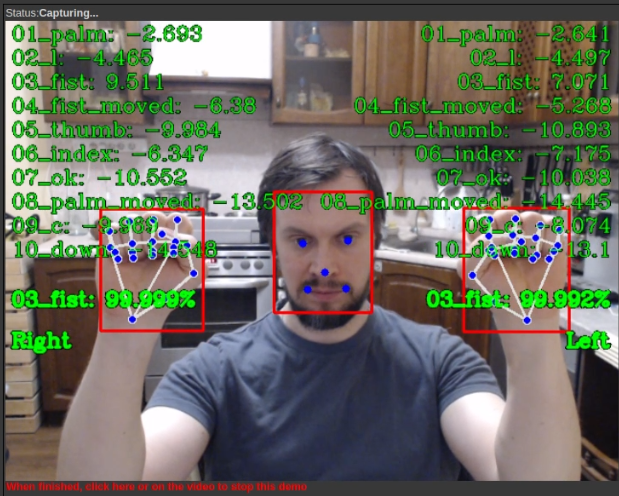

In [4]:
# !pip install ipython
from IPython.display import Image
print('Screenshot')
Image("./Screenshot.png", width=320, height=240) 

## Вывод<a class="anchor" id="summary"></a>

Я разработал модель, которая осуществляет детекцию лица человека, а также распознаёт показываемые им жесты. Модель обучалась на датасете https://www.kaggle.com/gti-upm/leapgestrecog. Использовался трёхслойный классификатор. Для разметки рук (landmarks) я использовал библиотеку mediapipe, специально заточенную под эти задачи. В итоге модель способна с достаточно большой вероятностью определять жесты обеими руками. Весь процесс детекции выводится на экран. 